# Трассировка лучей


## Подключаем библиотеки и описываем вспомогательные функции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

pi = np.arcsin(1)*2
eps = 2**(-10)
tiny_eps = 2**(-15)
min_significance = 0.01


class empty():
    def __init__(self):
        return None
    
class endles_none:
    def __init__(self, n):
        self.n = n
        return None
    def __iter__(self):
        return endles_none(self.n)
    def __next__(self):
        if self.n <= 0:
            raise StopIteration
        else:
            self.n -= 1
        return None
    
def none_func(n):
    def function(*args, **kwargs):
        if n > 1:
            return endles_none(n)
        elif n == 1:
            return None
        else:
            raise ValueError
    return function

def const_func(const):
    def function(*args, **kwargs):
        return const
    return function

def normalize(x):
    x /= np.linalg.norm(x)
    return x

def RGB(R, G, B, base=255):
    return np.array([R/base, G/base, B/base])

def smooth_max(x, y, alpha):
    return (x*np.exp(alpha*x) + y*np.exp(alpha*y))/(np.exp(alpha*x) + np.exp(alpha*y))

def V3_gradient(func, point):
    x = np.array([1.,0,0])
    y = np.array([0,1.,0])
    z = np.array([0,0,1.])
    return np.array([(func(point+eps*x) - func(point-eps*x))/(2*eps),
                     (func(point+eps*y) - func(point-eps*y))/(2*eps),
                     (func(point+eps*z) - func(point-eps*z))/(2*eps)])
    

## Алгоритмы отрисовки и трассировки

In [2]:
def render_image (camera, scene, screen, *, status = 5, depth=5):
    w = screen.w
    h = screen.h
    
    image = np.zeros((h, w, 3))
    
    # ----- status output -----
    procents = 0
    if 0 < status <= 100:
        print(0,'%')
        start_t = time.time()
        last_t = start_t
        
    for i in range(h):
        for k in range(w):
            image[i][k] = camera(i,k, trace_ray, scene, depth)
        
        # ----- status output -----
        if 0 < status <= 100:
            if procents < ((i/h)*100) // status:
                tmp = time.time()
                #print(i/h*100,'% dt -', tmp - last_t)
                print("%.2f%s %.3f %s" % (i/h*100, "%", tmp - last_t, "seconds"))
                last_t = tmp
                procents = ((i/h)*100) // status
    # ----- status output -----
    if 0 < status <= 100:
        end_t = time.time()
        print("%s %.3f %s" % ("100%", end_t - start_t, "seconds"))
    
    return image

def trace_ray (scene, start, ray, depth=5, significance=1, weight=1):
    if (depth <= 0) or (weight < min_significance):
        return scene.ambience_light

    light = np.array([-12.0, 8, -7.0])
    
    color = np.ones((3))
    alpha = 0.4
    normal, dist, obj = scene.get_normal(start, ray)
    fog, fog_color = scene.fogg(start, ray, dist)
    if normal is not None:
        ans = np.zeros(3)
        point = start + ray*dist
        color = obj.get_color(point)
        mirror = obj.get_mirror(point)
        diffuse = obj.get_diffuse(point)
            
        for light in scene.lights:
            tmp = np.sum(normalize(light[0]-point) * normal)
            if tmp < 0:
                tmp *= -1
            _, light_dist, _ = scene.get_normal(point + normalize(light[0]-point)*eps, normalize(light[0]-point))
            if light_dist >= np.linalg.norm(light[0]-point):
                light_fog, lf_color = scene.fogg(point, normalize(light[0]-point), np.linalg.norm(light-point))
                ans += color * tmp * diffuse * ((1-light_fog) + light_fog*lf_color) * light[1]
                specular = obj.get_specular(normalize(light[0]-point), ray, normal)
                ans += specular * light[1]*(1-light_fog)

        if mirror > 0:
            ray -= 2*normal*np.sum(normal*ray)
            ray = normalize(ray)
            ans += mirror * trace_ray(scene, point + eps*ray, ray, depth-1, 1, weight*mirror*(1-fog))

    else:
        ans = scene.distant_color(start, ray)
    return np.minimum(fog*fog_color + (1-fog)*ans, RGB(1,1,1,1))

## Описание объектов сцены

In [3]:
class render_object:
    def __init__(self, normals, material):
        self.get_normal = normals
        self.get_color = material.color
        self.get_specular = material.specular
        self.get_diffuse = material.diffuse
        self.get_mirror = material.mirror
        return None

class scene:
    def __init__(self, render_objects, scene_lights, distant_color_func, ambience_color=np.zeros(3), fogg=const_func((0,RGB(0,0,0)))):
        self.objects = render_objects
        self.lights = scene_lights
        self.ambience_light = ambience_color
        self.distant_color = distant_color_func
        self.fogg = fogg
        return None
    
    def get_normal(self, start, ray):
        normal = None
        distance = np.inf
        curent_obj = None
        for obj in self.objects:
            tmp_normal, tmp_distance = obj.get_normal(start, ray, distance)
            if tmp_distance < distance:
                distance = tmp_distance
                normal = tmp_normal
                curent_obj = obj
        return normal, distance, curent_obj

def sphere(Position, R):
    def normal(start, ray, *args):
        a = np.dot(ray, ray)
        PS = start - Position
        b = 2 * np.dot(ray, PS)
        c = np.dot(PS, PS) - R * R
        disc = b * b - 4 * a * c
        if disc > 0:
            distSqrt = np.sqrt(disc)
            q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
            t0 = q / a
            t1 = c / q
            t0, t1 = min(t0, t1), max(t0, t1)
            if t1 >= 0:
                if t0 < 0:
                    return normalize(start + ray*t1 - Position), t1
                else:
                    return normalize(start + ray*t0 - Position), t0
        return None, np.inf
    return normal

def plane(Position, Direction):
    Direction = normalize(Direction)
    def normal(start, ray, *args):
        if np.sum((Position - start) * Direction) * np.sum(ray * Direction) <= 0:
            return None, np.inf
        else:
            return Direction, np.sum((Position - start) * Direction)/np.sum(ray * Direction)
    return normal

### Описание SDF с потдержкой CSG и преобразования SDF в объкты

In [33]:
class SDF_function:
    def __init__(self, func, gradient=None):
        self.distance = func
        if gradient is not None:
            def grad(*args, **kwargs):
                return gradient(func, *args, **kwargs)
            self.gradient = grad
        return None
    
    def add_gradient(self, gradient=None):
        def grad(*args, **kwargs):
            return gradient(self.distance, *args, **kwargs)
        self.gradient = grad
        return self
    
    def __call__(self, *args, **kwargs):
        return self.distance(*args, **kwargs)
    
    def __add__(self, other):
        def func(*args, **kwargs):
            return min(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __mul__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __sub__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), -other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __neg__(self):
        def func(*args, **kwargs):
            return -self.distance(*args, **kwargs)
        return SDF_function(func)
    
    def smooth(self, other, alpha=0):
        def func(*args, **kwargs):
            return smooth_max(self.distance(*args, **kwargs), other.distance(*args, **kwargs), alpha)
        return SDF_function(func)
    
def smooth_SDF(funcs, alpha, **kwargs):
    def func(*args, **kwargs):
        numerator = 0
        denominator = 0
        for f in funcs:
            x = f(*args, **kwargs)
            numerator += x*np.exp(alpha*x)
            denominator += np.exp(alpha*x)
        return numerator/denominator
    return SDF_function(func, **kwargs)

def object_from_SDF(sdf, material, delta=0.90):
    def normal(start, ray, best=np.inf):
        point = np.copy(start)
        tmp = abs(sdf(point))
        if (tmp > best):
            return None, np.inf
        prev = 0
        while (tmp < 1/tiny_eps) and (np.sum((point - start)*ray) < best):
            point += ray*delta*tmp
            prev = tmp
            tmp = abs(sdf(point))
            if (tmp <= tiny_eps) and (tmp <= prev):
                if (np.sum((point - start)*ray) > 0):
                    return normalize(sdf.gradient(point)), np.sum((point - start)*ray)
                else:
                    break
        return None, np.inf
    return render_object(normal, material)

def sphere_SDF(position, R):
    def func(x):
        return np.linalg.norm(x-position) - R
    return SDF_function(func)

def inf_cylinder_SDF(position, R, direction):
    dir = normalize(direction)
    def func(x):
        return np.linalg.norm(np.cross(x-position, dir)) - R
    return SDF_function(func)

def plane_SDF(position, N):
    normal = normalize(N)
    def func(x):
        return np.sum((x-position)*normal)
    return SDF_function(func)

def cylinder_SDF(point_1, point_2, R):
    pillar = inf_cylinder_SDF(point_1, R, point_1 - point_2)
    end_of_pillar_1 = plane_SDF(point_1, point_1 - point_2)
    end_of_pillar_2 = plane_SDF(point_2, point_2 - point_1)
    return end_of_pillar_1*pillar*end_of_pillar_2


## Бликовая составляющая

In [5]:
def G(L, V, N, H):
    ans = min(np.sum(N*V)/np.sum(H*V), np.sum(N*L)/np.sum(H*L))
    ans = min(1, 2*ans*np.sum(N*H))
    return max(0, ans)

# Beckmann distribution
def D_Beckmann(N, H, Y, sigma_x, sigma_y):
    cos_2 = np.sum(N*H)**2
    flat_H = normalize(H - np.sum(N*H)*N)
    cos_fi_2 = np.sum(flat_H*Y)**2
    test = np.linalg.norm(Y)
    if test != test:
        ans = np.exp(-(1/(sigma_x*sigma_y))*(1-cos_2)/(cos_2))
    else:
        ans = np.exp(-((1- cos_fi_2)/(sigma_x**2) + cos_fi_2/(sigma_y**2))*(1-cos_2)/(cos_2))
    return ans/(pi*sigma_x*sigma_y*np.sum(N*H)**4)

def F(L, H, eta):
    c = np.sum(L*H); g = eta**2 + c**2 - 1
    t1 = g-c; t2 = g+c
    return 0.5*((t1**2)/(t2**2))*(1+((c*t2-1)**2)/((c*t1+1)**2))

# eta - коэфицент преломления
def create_anisotropic_function(sigma_x, sigma_y, eta, Up_direction = RGB(0,1,0,1)):
    up = normalize(Up_direction)
    def specular_func(light, ray, normal):
        Y = normalize(up - np.sum(normal*up)*normal)
        H = normalize(light - ray)
        numerator = F(light, H, eta)*D_Beckmann(normal, H, Y, sigma_x, sigma_y)*G(light, -ray, normal, H)
        denominator = 4 * np.sum(normal*light) * np.sum(-ray*normal)
        return numerator/denominator
    return specular_func

## Материал

In [6]:
class material:
    def __init__(self, **kwargs):
        self.specular = kwargs['specular']
        self.diffuse = kwargs['diffuse']
        self.mirror = kwargs['mirror']
        self.color = kwargs['color']
        return None

    def __call__(self, **kwargs):
        if 'specular' in kwargs.keys():
            get_specular = kwargs['specular']
        else:
            get_specular = self.specular
        if 'diffuse' in kwargs.keys():
            get_diffuse = kwargs['diffuse']
        else:
            get_diffuse = self.diffuse
        if 'mirror' in kwargs.keys():
            get_mirror = kwargs['mirror']
        else:
            get_mirror = self.mirror
        if 'color' in kwargs.keys():
            get_color = kwargs['color']
        else:
            get_color = self.color
        return material(specular=get_specular, diffuse=get_diffuse, mirror=get_mirror, color=get_color)

## Туман

In [7]:
def simple_fog(intensity, fog_collor):
    def fogg(start, ray, dist):
        if dist == np.inf:
            return 1, fog_collor(start, ray, dist)
        return (1 - np.exp(-dist*intensity)), fog_collor(start, ray)
    return fogg

# F(z)=exp(-g(z)) - видимость в точке
# g(z) - затуманеность точки
# I = Integral g(z(l))dl from start to end - затуманеность пути
# 1 - exp(-I) - вклад тумана
# G = Integral g(z)dz

def layered_fog(intensity_func, Antiderivative_intensity_func, collor_func, normal=np.array([0,1.,0])):
    def I(start, ray, dist):
        cos_ = np.sum(normal*ray)
        if cos_ == 0:
            if dist != np.inf:
                return dist*intensity_func(start[1])
            elif intensity_func(start[1]) > 0:
                return np.inf
            else:
                return 0
        else:
            return (Antiderivative_intensity_func(start[1] + dist*cos_) -
                    Antiderivative_intensity_func(start[1]))/cos_
    def fogg(start, ray, dist):
        return (1 - np.exp(-I(start, ray, dist))), collor_func(start, ray, dist)
    return fogg

def linear_gradient_fog(height, intensity, collor, normal=np.array([0,1.,0])):
    def fog_g(z):
        return np.maximum(0, height-z)*intensity
    def fog_G(z):
        if z <= height:
            return -((z-height)**2)*intensity/2
        else:
            return 0
    return layered_fog(fog_g, fog_G, const_func(collor), normal)

## Описание камеры

In [8]:
class axis:
    def __init__(self, position, x_direction, y_direction, z_direction):
        self.position = position
        self.dx = normalize(x_direction)
        self.dy = normalize(y_direction)
        self.dz = normalize(z_direction)
        self.forward = self.dx;
        self.back = -self.dx;
        self.up = self.dy;
        self.down = -self.dy;
        self.right = self.dz;
        self.left = -self.dz;
        return None

class camera:
    def __init__(self, axis, view_tangent, focus_distance, aperture = np.array([[[0.,0,0],1]])):
        self.axis = axis
        self.view_tangent = view_tangent
        self.focal_length = focus_distance
        self.aperture = aperture
        return None
    
    def __call__(self, i,k, trace_ray, scene, depth):
        pixel_pos = self.axis.forward + self.pix_size*(self.axis.right*(k - self.w/2) + self.axis.up*(self.h/2 - i))
        ray = normalize(pixel_pos)
        rays = self.ray_array(self.axis.position, ray)
        pix_color = RGB(0,0,0)
        for ray in rays:
            pix_color += ray[2]*trace_ray(scene, ray[0], ray[1], depth)
        return pix_color

    def insert_matrix(self, matrix):
        self.pix_size = 2*self.view_tangent/np.linalg.norm([matrix.h,matrix.w])
        self.w = matrix.w
        self.h = matrix.h

    def ray_array(self, start, ray):
        principal = ray*self.focal_length/np.sum(ray*self.axis.forward)
        ans = np.array([np.array([start + point[0], normalize(principal - point[0]), point[1]]) for point in self.aperture])
        #ans = np.array([[start, ray, 1]])
        return ans

def creat_ring_aperture(dot_count, radius):
    return np.array([np.array([radius*RGB(0,np.sin(2*pi*i/dot_count),np.cos(2*pi*i/dot_count),1), 1/dot_count]) for i in range(dot_count)])

## Двумерные пост-эффекты

In [9]:
def saturation_effect(img):
    tmp = np.copy(img)
    for row in tmp:
        for pix in row:
            pix += -pix + 2*pix**4 - 6*pix**3 + 5*pix**2
    return tmp

def sunset_effect(img):
    tmp = np.copy(img)
    for row in tmp:
        for pix in row:
            pix += - pix + pix*RGB(2,0,1,3) + pix[1]*pix*RGB(1,3,2,3)
    return tmp

def cacao_effect(img):
    tmp = np.copy(img)
    for row in tmp:
        for pix in row:
            V = np.max(pix)
            pix *= (np.sin(V*pi)/pi + V)**(0.2)
            pix += -pix + 2*pix**4 - 6*pix**3 + 5*pix**2
            pix += - pix + pix*RGB(2,1,0,3) + pix[2]*pix*RGB(1,2,3,3)
    return tmp

def custom_effect(img):
    return sunset_effect(saturation_effect(img))

## Задание сцен


In [10]:
'''
    ^ y
    |  
    | 
    |
  :)o--------> x
   /
  /
 /
L z
'''
def creat_ring_light(dot_count, radius, color):
    return np.array([np.array([radius*RGB(0,np.sin(2*pi*i/dot_count),np.cos(2*pi*i/dot_count),1), color/dot_count]) for i in range(dot_count)])

def creat_long_light(dot_count, start, end, color):
    return np.array([np.array([start + (end-start)*i/(dot_count-1), color/(dot_count-1)]) for i in range(dot_count)])

def my_ambient_collor(start, ray, *args):
    high = (np.sum(ray*normalize(np.array([0.1,1,-0.3]))) + 1)/2
    return high*RGB(117, 187, 253) + (1-high)*RGB(243, 148, 98)

glossy_metal_spec = create_anisotropic_function(0.1,0.1,3)
yellow_metal = material(mirror=const_func(0.7), color=const_func(RGB(1.,1,0,1)), diffuse=const_func(0.3),specular=glossy_metal_spec)
black_mirror = material(mirror=const_func(0.95), color=const_func(RGB(0.,0,0)), diffuse=const_func(0.05),specular=glossy_metal_spec)

metal_spec = create_anisotropic_function(0.07,0.8,2.2,np.array([2.,1,0.5]))
blue_metal = material(mirror=const_func(0.2), color=const_func(RGB(114,154,211)), diffuse=const_func(0.8),specular=metal_spec)

plastic_spec = create_anisotropic_function(0.4, 0.2, 4)
green_ball = material(mirror=const_func(0.1), color=const_func(RGB(86,255,148)), diffuse=const_func(0.9), specular=plastic_spec)

plane_spec = create_anisotropic_function(0.2, 0.2, 1.25)
gray_floor = material(mirror=const_func(0.25), color=const_func(RGB(1.,1,1,1)), diffuse=const_func(0.75), specular=plane_spec)

### Сцена 1

In [65]:
objs_1 = np.array([
    render_object(sphere(np.array([35,40,-30]), 40), black_mirror),
    render_object(sphere(np.array([10,2.5,-11]), 2.5), yellow_metal),
    render_object(sphere(np.array([32,2.5,2]), 2.5), green_ball),
    render_object(sphere(np.array([20,2.5,-9]), 2.5), green_ball),
    render_object(sphere(np.array([12,2.5,-1]), 2.5), yellow_metal),
    render_object(sphere(np.array([8.5,2.5,4]), 2.5), green_ball),
    render_object(sphere(np.array([12,2.5,13]), 2.5), yellow_metal),
    render_object(sphere(np.array([22,10,12]), 10), blue_metal),
    render_object(plane(np.array([0,0,0]), np.array([0.0,1.0,0.0])), gray_floor)
])
lights_1 = creat_long_light(9, np.array([-12.0, 6, -12.0]), np.array([-8.0, 10, -2.0]), RGB(1,1,1,1))
my_simple_fog = simple_fog(0.05, my_ambient_collor)

scene_1 = scene(objs_1, lights_1, my_ambient_collor, RGB(17, 15, 11), my_simple_fog)

camera_aperture = creat_ring_aperture(9, 0.6)
camera_axis = axis(np.array([-1.4, 7.5, 0.]), np.array([7.0, -1.2, 0]), np.array([1.2, 7.0, 0]), np.array([0, 0, 1.0]))

camera_1 = camera(camera_axis, 1.4, 14.0, camera_aperture)

### Сцена 2

In [99]:
black_point = np.array([35.,55,-5])
joint_point_1 = np.array([25.75, 8.5, 17])
joint_point_2 = np.array([18.75, 6, -30])
joint_point_3 = np.array([59, 10.5, -13])
#supportpoint = np.array([15.,0,-9])
radius = 3
alpha = 1.7

pillar_1 = inf_cylinder_SDF(black_point, radius, black_point - joint_point_1)
pillar_2 = inf_cylinder_SDF(black_point, radius, black_point - joint_point_2)
pillar_3 = inf_cylinder_SDF(black_point, radius, black_point - joint_point_3)
#pillar_12 = cylinder_SDF(joint_point_1, joint_point_2, radius)
pillar_12 = cylinder_SDF((joint_point_1*3 + joint_point_3)/4, (joint_point_2*3 + joint_point_3)/4, radius)
pillar_23 = cylinder_SDF(joint_point_2, joint_point_3, radius)
pillar_31 = cylinder_SDF(joint_point_3, joint_point_1, radius)
pilars = pillar_1 + pillar_2 + pillar_3 + pillar_12 + pillar_23 + pillar_31
pilars = smooth_SDF([pillar_1,pillar_2,pillar_3,pillar_12,pillar_23,pillar_31], -1)

floor_edge = plane_SDF(np.array([0.,0,0]), np.array([0.,-1,0]))
joint_ball_1 = -sphere_SDF(joint_point_1, alpha*radius)
joint_ball_2 = -sphere_SDF(joint_point_2, alpha*radius)
joint_ball_3 = -sphere_SDF(joint_point_3, alpha*radius)
black_ball = -sphere_SDF(black_point, 40)

objs_2 = np.array([
    render_object(sphere(black_point, 40), black_mirror(color=const_func(RGB(1.,1,0,1)))),
    render_object(sphere(joint_point_1, alpha*radius), yellow_metal),
    render_object(sphere(joint_point_2, alpha*radius), yellow_metal),
    render_object(sphere(joint_point_3, alpha*radius), yellow_metal),
    render_object(sphere(np.array([27,2,-22]), 2), green_ball),
    render_object(sphere(np.array([35,2,5]), 2), green_ball),
    render_object(sphere(np.array([21,2,12]), 2), green_ball),
    render_object(sphere(np.array([13,2,-5]), 2), green_ball),
    render_object(sphere(np.array([10,2,-28]), 2), green_ball),
    render_object(sphere(np.array([37,2,-9]), 2), green_ball),
    render_object(sphere(np.array([6,2,6]), 2), green_ball),
    render_object(sphere(np.array([18,2,22]), 2), green_ball),
    render_object(sphere(np.array([7,2,-20]), 2), green_ball),
    render_object(plane(np.array([0,0,0]), np.array([0.0,1.0,0.0])), gray_floor),
    object_from_SDF(smooth_SDF([pilars,floor_edge,black_ball,joint_ball_1,joint_ball_2,joint_ball_3], 1).add_gradient(V3_gradient), blue_metal, delta=0.8)
])
lights_2 = np.array([[np.array([-10.0, 12, -47.0]), RGB(1,1,1,1)]])
my_layered_fog = linear_gradient_fog(11, 0.005, RGB(127, 42, 127)) #RGB(50, 50, 130)

scene_2 = scene(objs_2, lights_2, my_ambient_collor, RGB(17, 15, 11), my_layered_fog)

camera_axis = axis(np.array([-44.5,18.75,-5.1]), np.array([1.0, -0.1, 0]), np.array([0.1, 1.0, 0]), np.array([0, 0, 1.0]))
camera_2 = camera(camera_axis, 0.6, 14.0)

## Просчитываем сцену

Небольшие приготавления

In [100]:
from google.colab import drive
# оцениваем время расчётов
def approximate_time(camera, scene, camera_screen, depth):
    tg = camera_screen.w/camera_screen.h
    little_matrix = empty(); little_matrix.w = int(tg*10+1); little_matrix.h = 10
    camera.insert_matrix(little_matrix)
    start_t = time.time()
    render_image(camera, scene, little_matrix, status = 20, depth=depth)  
    end_t = time.time()
    camera.insert_matrix(camera_screen)
    apr_time = (end_t - start_t)*(camera_screen.w/little_matrix.w)*(camera_screen.h/little_matrix.h)
    print("approximate %.3f seconds" % apr_time)

# Выбираем подходящее разрешение
camera_screen = empty();
#camera_screen.w = 1920; camera_screen.h = 1080
#camera_screen.w = 1440; camera_screen.h = 810
#camera_screen.w = 960; camera_screen.h = 540
camera_screen.w = 640; camera_screen.h = 360
#camera_screen.w = 400; camera_screen.h = 240
#camera_screen.w = 300; camera_screen.h = 180
#camera_screen.w = 200; camera_screen.h = 120
#camera_screen.w = 150; camera_screen.h = 90
#camera_screen.w = 100; camera_screen.h = 60
#camera_screen.w = 90; camera_screen.h = 53
#camera_screen.w = 60; camera_screen.h = 35

0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


20.00% 3.155 seconds
40.00% 2.603 seconds
60.00% 2.162 seconds
80.00% 2.495 seconds
100% 11.890 seconds
approximate 15219.724 seconds
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0 %
2.22% 313.139 seconds
4.17% 254.688 seconds
6.11% 261.427 seconds
8.06% 259.789 seconds
10.00% 261.690 seconds
12.22% 298.804 seconds
14.17% 258.698 seconds
16.11% 261.138 seconds
18.06% 258.320 seconds
20.00% 252.710 seconds
22.22% 285.172 seconds
24.17% 261.178 seconds
26.11% 271.595 seconds
28.06% 285.922 seconds
30.00% 306.481 seconds
32.22% 353.924 seconds
34.17% 299.965 seconds
36.11% 294.710 seconds
38.06% 288.408 seconds
40.00% 285.067 seconds
42.22% 328.932 seconds
44.17% 292.467 seconds
46.11% 293.262 seconds
48.06% 299.667 seconds
50.00% 300.089 seconds
52.22% 331.638 seconds
54.17% 279.783 seconds
56.11% 253.713 seconds
58.06% 252.152 seconds
60.00% 245.617 seconds
62.22% 253.908 seconds
64.17% 210.978 seconds
6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


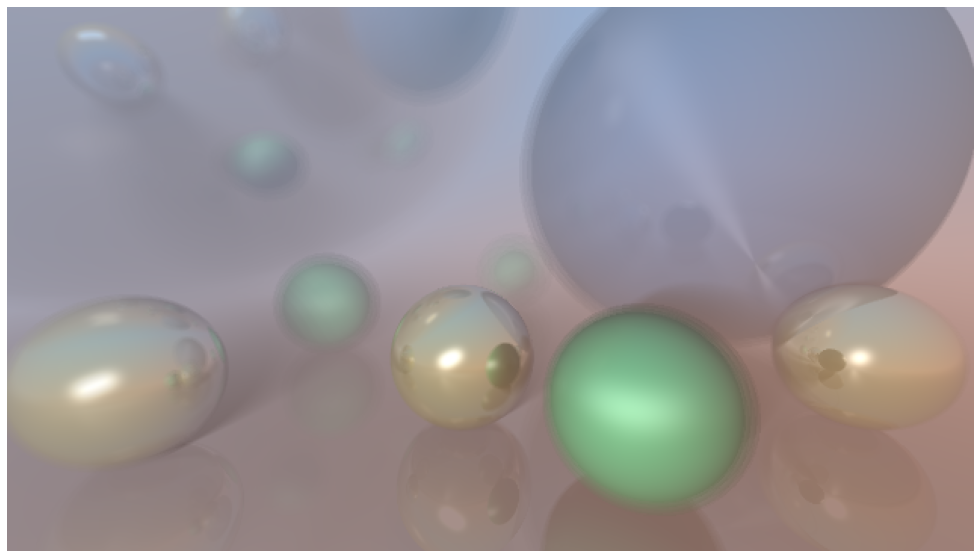

In [71]:
camera_1.insert_matrix(camera_screen)
approximate_time(camera_1, scene_1, camera_screen, depth = 16)
drive.mount('/content/drive') 
img_1 = render_image(camera_1, scene_1, camera_screen, status = 2, depth = 16)

plt.imsave('/content/drive/My Drive/Colab Notebooks/image_1.png', np.minimum(img_1,1))
drive.flush_and_unmount()

plt.figure(figsize=(20,10))
plt.axis(False)
plt.imshow(img_1)

0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars


20.00% 1.175 seconds
40.00% 1.978 seconds
60.00% 2.789 seconds
80.00% 0.962 seconds
100% 7.373 seconds
approximate 9437.678 seconds
Mounted at /content/drive
0 %
5.00% 231.716 seconds
10.00% 214.879 seconds
15.00% 239.307 seconds
20.00% 341.675 seconds
25.00% 438.393 seconds
30.00% 580.412 seconds
35.00% 583.724 seconds
40.00% 585.458 seconds
45.00% 506.266 seconds
50.00% 926.377 seconds
55.00% 793.090 seconds
60.00% 581.929 seconds
65.00% 600.180 seconds
70.00% 401.826 seconds
75.00% 315.874 seconds
80.00% 338.818 seconds
85.00% 407.477 seconds
90.00% 464.232 seconds
95.00% 295.098 seconds
100% 9118.915 seconds


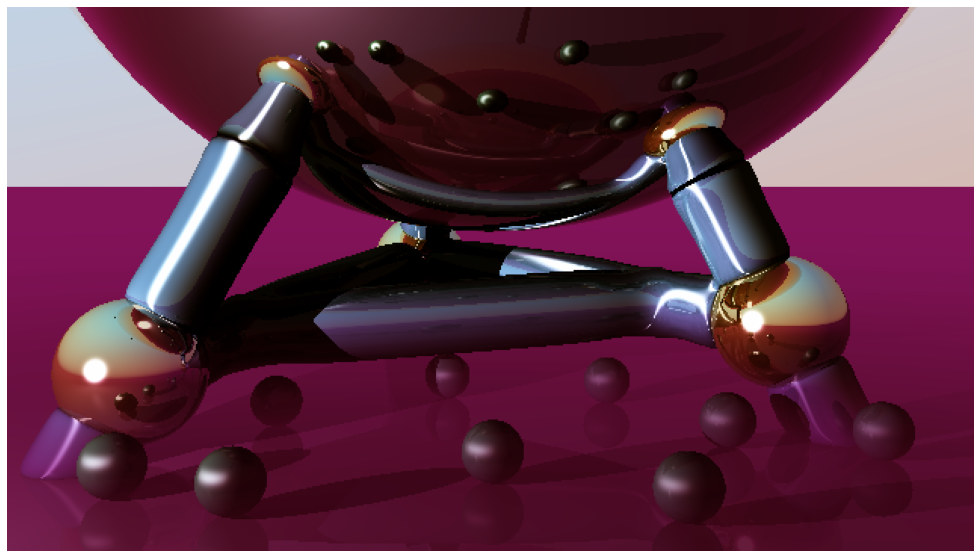

In [101]:
camera_2.insert_matrix(camera_screen)
approximate_time(camera_2, scene_2, camera_screen, depth = 16)
drive.mount('/content/drive') 
img_2 = render_image(camera_2, scene_2, camera_screen, depth = 16)
cacao_image_2 = cacao_effect(img_2) #пост-эффект

plt.imsave('/content/drive/My Drive/Colab Notebooks/cacao_image_2.png', cacao_image_2)
plt.imsave('/content/drive/My Drive/Colab Notebooks/image_2.png', img_2)
drive.flush_and_unmount()

plt.figure(figsize=(20,10))
plt.axis(False)
plt.imshow(cacao_image_2)

### применяем различные пост-эффекты

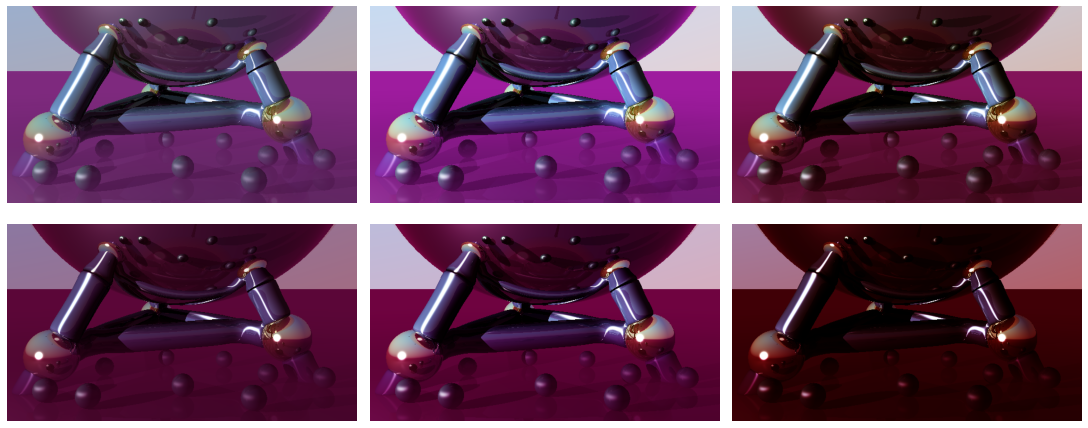

In [102]:
import matplotlib.gridspec as gridspec

fig2 = plt.figure(constrained_layout=True, figsize=(15,6))
spec2 = gridspec.GridSpec(nrows=2, ncols=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])
f2_ax4 = fig2.add_subplot(spec2[1, 0])
f2_ax5 = fig2.add_subplot(spec2[1, 1])
f2_ax6 = fig2.add_subplot(spec2[1, 2])
f2_ax1.axis(False); f2_ax2.axis(False); f2_ax3.axis(False);
f2_ax4.axis(False); f2_ax5.axis(False); f2_ax6.axis(False);
f2_ax1.imshow(img_2); f2_ax2.imshow(saturation_effect(img_2)); f2_ax3.imshow(cacao_effect(img_2));
f2_ax4.imshow(sunset_effect(img_2)); f2_ax5.imshow(custom_effect(img_2)); f2_ax6.imshow(cacao_effect(sunset_effect(img_2)));